# 🏪 Store Sales - Enhanced Time Series Forecasting
### Advanced Model with Target Encoding, Multi-Seed Averaging & Stacking

**Goal**: Improve RMSLE from 0.48622 to <0.40

**Key Improvements**:
1. Target encoding for categorical variables
2. Store-family specific aggregations
3. Interaction features
4. Multi-seed averaging (3 seeds per model)
5. Stacking ensemble with Ridge meta-model
6. Optimized hyperparameters

---

## 1️⃣ Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


## 2️⃣ Data Loading

In [2]:
# Load all datasets
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Date range: {train.date.min()} to {train.date.max()}')
print(f'Test dates: {test.date.min()} to {test.date.max()}')

print(f'\n🏬 Number of stores: {train.store_nbr.nunique()}')
print(f'🛒 Number of product families: {train.family.nunique()}')

Train shape: (3000888, 6)
Test shape: (28512, 5)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test dates: 2017-08-16 00:00:00 to 2017-08-31 00:00:00

🏬 Number of stores: 54
🛒 Number of product families: 33


## 3️⃣ Data Preprocessing

### 3.1 Oil Prices Processing

In [3]:
def process_oil(oil_df):
    """Fill missing oil prices using interpolation"""
    full_dates = pd.date_range(start=oil_df['date'].min(), end=oil_df['date'].max())
    oil_complete = pd.DataFrame({'date': full_dates})
    oil_complete = oil_complete.merge(oil_df, on='date', how='left')
    
    oil_complete['dcoilwtico'] = oil_complete['dcoilwtico'].interpolate(method='linear', limit_direction='both')
    oil_complete['oil_change'] = oil_complete['dcoilwtico'].diff()
    oil_complete['oil_change_7d'] = oil_complete['dcoilwtico'].diff(7)
    oil_complete['oil_rolling_mean_30'] = oil_complete['dcoilwtico'].rolling(30, min_periods=1).mean()
    
    return oil_complete

oil_processed = process_oil(oil)
print(f'✅ Oil data processed: {len(oil_processed)} days')

✅ Oil data processed: 1704 days


### 3.2 Holidays Processing

In [4]:
def process_holidays(holidays_df):
    """Process holidays - exclude transferred days"""
    holidays_clean = holidays_df[holidays_df['transferred'] == False].copy()
    
    holidays_clean['is_national'] = (holidays_clean['locale'] == 'National').astype(int)
    holidays_clean['is_regional'] = (holidays_clean['locale'] == 'Regional').astype(int)
    holidays_clean['is_local'] = (holidays_clean['locale'] == 'Local').astype(int)
    
    holiday_agg = holidays_clean.groupby('date').agg({
        'is_national': 'max',
        'is_regional': 'max',
        'is_local': 'max'
    }).reset_index()
    
    return holiday_agg

holidays_processed = process_holidays(holidays)
print(f'✅ Holidays processed: {len(holidays_processed)} unique holiday dates')

✅ Holidays processed: 300 unique holiday dates


## 4️⃣ Feature Engineering

### 4.1 Merge Base Data

In [5]:
def merge_base_features(df, oil_df, stores_df, holidays_df):
    """Merge all base datasets"""
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')
    df = df.merge(holidays_df, on='date', how='left')
    df[['is_national', 'is_regional', 'is_local']] = df[['is_national', 'is_regional', 'is_local']].fillna(0)
    
    return df

train_merged = merge_base_features(train, oil_processed, stores, holidays_processed)
test_merged = merge_base_features(test, oil_processed, stores, holidays_processed)

print(f'✅ Base features merged')
print(f'Train shape: {train_merged.shape}')
print(f'Test shape: {test_merged.shape}')

✅ Base features merged
Train shape: (3000888, 17)
Test shape: (28512, 16)


In [6]:
def create_holiday_distance_features(df, holidays_df):
    """Calculate days to/from next/previous holiday"""
    print('Creating holiday distance features...')
    
    # 1. Use pd.DatetimeIndex to get unique, sorted dates correctly
    holiday_dates = pd.DatetimeIndex(holidays_df['date'].unique()).sort_values()
    
    # 2. Extract values safely for numpy operations
    holiday_dates_np = holiday_dates.values
    
    # 3. Get unique dates from the main dataframe
    unique_df_dates = pd.DatetimeIndex(df['date'].unique()).sort_values()
    
    date_map_prev = {}
    date_map_next = {}
    
    for date in unique_df_dates:
        # Convert pandas Timestamp to numpy datetime64
        d_np = np.datetime64(date)
        
        # Find insertion point
        idx = np.searchsorted(holiday_dates_np, d_np)
        
        d_prev = 100 # default cap
        d_next = 100 # default cap
        
        if idx > 0:
            # Days since previous holiday
            d_prev = (d_np - holiday_dates_np[idx-1]).astype('timedelta64[D]').astype(int)
        
        if idx < len(holiday_dates_np):
            # If current date is a holiday, distance is 0
            if holiday_dates_np[idx] == d_np:
                d_next = 0
                d_prev = 0
            else:
                # Days until next holiday
                d_next = (holiday_dates_np[idx] - d_np).astype('timedelta64[D]').astype(int)
            
        date_map_prev[date] = d_prev
        date_map_next[date] = d_next
    
    # Map precomputed values back (ensure df['date'] is datetime for mapping)
    df['date'] = pd.to_datetime(df['date'])
    df['days_since_holiday'] = df['date'].map(date_map_prev)
    df['days_until_holiday'] = df['date'].map(date_map_next)
    
    # Log transform to reduce skew
    df['days_since_holiday_log'] = np.log1p(df['days_since_holiday'])
    df['days_until_holiday_log'] = np.log1p(df['days_until_holiday'])
    
    return df
print("done")

done


### 4.2 Time-Based Features

In [7]:
def create_time_features(df):
    """Create comprehensive time-based features"""
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['week_of_month'] = (df['day'] - 1) // 7 + 1
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Binary flags
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = (df['month'] == 1).astype(int)
    df['is_year_end'] = (df['month'] == 12).astype(int)
    
    # Payday features
    df['is_payday'] = ((df['day'] == 15) | df['is_month_end']).astype(int)
    df['days_to_payday'] = df.apply(lambda row: min(
        abs(row['day'] - 15),
        abs(row['day'] - pd.Timestamp(row['date']).days_in_month)
    ), axis=1)
    
    # Earthquake impact
    df['earthquake_impact'] = ((df['date'] >= '2016-04-16') & (df['date'] <= '2016-05-31')).astype(int)
    
    return df

train_merged = create_time_features(train_merged)
test_merged = create_time_features(test_merged)

print('✅ Time features created')

✅ Time features created


### 4.3 Store-Family Aggregations (NEW)

In [8]:
def create_store_family_features(df):
    """Create store-family specific aggregation features"""
    print('Creating store-family aggregations...')
    
    # Ensure dayofweek exists if not already there
    if 'dayofweek' not in df.columns:
        df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek
    
    # List of features we are about to create
    target_cols = [
        'store_family_mean_sales', 'store_family_median_sales', 'store_family_std_sales',
        'type_family_mean_sales', 'cluster_family_mean_sales', 'dow_family_mean_sales'
    ]
    
    # Prevent KeyError: Drop columns if they already exist (e.g. from a previous run)
    df = df.drop(columns=[c for c in target_cols if c in df.columns])
    
    # Only use training data for aggregations
    train_data = df[df['sales'].notna()].copy()
    
    if train_data.empty:
        print("Warning: No training data found (sales column is all NaN).")
        return df

    # 1. Store-Family Mean
    agg = train_data.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
    agg.columns = ['store_nbr', 'family', 'store_family_mean_sales']
    df = df.merge(agg, on=['store_nbr', 'family'], how='left')
    
    # 2. Store-Family Median
    agg = train_data.groupby(['store_nbr', 'family'])['sales'].median().reset_index()
    agg.columns = ['store_nbr', 'family', 'store_family_median_sales']
    df = df.merge(agg, on=['store_nbr', 'family'], how='left')
    
    # 3. Store-Family Std
    agg = train_data.groupby(['store_nbr', 'family'])['sales'].std().reset_index()
    agg.columns = ['store_nbr', 'family', 'store_family_std_sales']
    df = df.merge(agg, on=['store_nbr', 'family'], how='left')
    
    # 4. Type-Family Mean (requires 'type' from stores metadata)
    if 'type' in df.columns:
        agg = train_data.groupby(['type', 'family'])['sales'].mean().reset_index()
        agg.columns = ['type', 'family', 'type_family_mean_sales']
        df = df.merge(agg, on=['type', 'family'], how='left')
    
    # 5. Cluster-Family Mean (requires 'cluster' from stores metadata)
    if 'cluster' in df.columns:
        agg = train_data.groupby(['cluster', 'family'])['sales'].mean().reset_index()
        agg.columns = ['cluster', 'family', 'cluster_family_mean_sales']
        df = df.merge(agg, on=['cluster', 'family'], how='left')
    
    # 6. Day of week - Family pattern
    agg = train_data.groupby(['dayofweek', 'family'])['sales'].mean().reset_index()
    agg.columns = ['dayofweek', 'family', 'dow_family_mean_sales']
    df = df.merge(agg, on=['dayofweek', 'family'], how='left')
    
    # Fill NaN with global means for the new columns
    # (Checking if column exists before filling to avoid KeyError)
    for col in target_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())
    
    return df
print("done")

done


### 4.4 Target Encoding for Categorical Variables (NEW)

In [9]:
def target_encode_feature(train_df, test_df, col, target='sales', n_folds=5, smoothing=10):
    """Target encoding with K-fold cross-validation to prevent leakage"""
    # Initialize encoded columns
    train_df[f'{col}_target_enc'] = 0
    test_df[f'{col}_target_enc'] = 0
    
    # Global mean for smoothing
    global_mean = train_df[target].mean()
    
    # K-fold encoding for train
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(train_df):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]
        
        # Calculate means and counts
        encoding = train_fold.groupby(col).agg(
            mean_target=(target, 'mean'),
            count=(target, 'count')
        ).reset_index()
        
        # Smoothing: (count * mean + smoothing * global_mean) / (count + smoothing)
        encoding['smoothed_mean'] = (
            encoding['count'] * encoding['mean_target'] + smoothing * global_mean
        ) / (encoding['count'] + smoothing)
        
        # Map to validation fold
        encoding_dict = dict(zip(encoding[col], encoding['smoothed_mean']))
        train_df.loc[val_idx, f'{col}_target_enc'] = val_fold[col].map(encoding_dict).fillna(global_mean)
    
    # Encode test using full training data
    encoding = train_df.groupby(col).agg(
        mean_target=(target, 'mean'),
        count=(target, 'count')
    ).reset_index()
    
    encoding['smoothed_mean'] = (
        encoding['count'] * encoding['mean_target'] + smoothing * global_mean
    ) / (encoding['count'] + smoothing)
    
    encoding_dict = dict(zip(encoding[col], encoding['smoothed_mean']))
    test_df[f'{col}_target_enc'] = test_df[col].map(encoding_dict).fillna(global_mean)
    
    return train_df, test_df

# Apply target encoding to categorical columns
print('Applying target encoding...')
cat_cols_to_encode = ['family', 'city', 'state', 'type']

for col in cat_cols_to_encode:
    train_merged, test_merged = target_encode_feature(train_merged, test_merged, col)
    print(f'  ✓ {col}')

print('✅ Target encoding completed')

Applying target encoding...
  ✓ family
  ✓ city
  ✓ state
  ✓ type
✅ Target encoding completed


### 4.5 Lag & Rolling Window Features

In [10]:
def create_lag_features(df):
    """Create lag and rolling window features"""
    df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    
    # Sales lags (16+ days to avoid leakage)
    lag_days = [16, 21, 28, 30, 60, 90, 182, 365]
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    # Rolling window statistics (shifted by 16 days)
    windows = [7, 14, 30, 60, 90]
    for window in windows:
        df[f'rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).std()
        )
        df[f'rolling_max_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).max()
        )
        df[f'rolling_min_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).min()
        )
    
    # Exponentially weighted moving average
    df['ewm_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).ewm(span=7, adjust=False).mean()
    )
    df['ewm_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).ewm(span=30, adjust=False).mean()
    )
    
    # Promotion lags
    df['promo_lag_16'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16)
    )
    df['promo_rolling_sum_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16).rolling(7, min_periods=1).sum()
    )
    
    return df

print('Creating lag features (this may take a few minutes)...')
full_data = pd.concat([train_merged, test_merged], axis=0, ignore_index=True)
full_data = create_lag_features(full_data)

# Split back
train_final = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_final = full_data[full_data['sales'].isna()].reset_index(drop=True)

print(f'✅ Lag features created')
print(f'Train shape: {train_final.shape}')
print(f'Test shape: {test_final.shape}')

Creating lag features (this may take a few minutes)...
✅ Lag features created
Train shape: (3000888, 74)
Test shape: (28512, 74)


### 4.6 Interaction Features (NEW)

In [11]:
def create_interaction_features(df):
    """Create interaction features"""
    # Promotion × Family (encoded)
    df['promo_x_family'] = df['onpromotion'] * df['family_target_enc']
    
    # Day of week × Family (encoded)
    df['dow_x_family'] = df['dayofweek'] * df['family_target_enc']
    
    # Oil price × Family (oil sensitivity varies by product)
    df['oil_x_family'] = df['dcoilwtico'] * df['family_target_enc']
    
    # Store × Family interaction (already have target encoding)
    df['store_x_family'] = df['store_nbr'] * df['family_target_enc']
    
    # Promotion × Weekend
    df['promo_x_weekend'] = df['onpromotion'] * df['is_weekend']
    
    # Promotion × Payday
    df['promo_x_payday'] = df['onpromotion'] * df['is_payday']
    
    return df

train_final = create_interaction_features(train_final)
test_final = create_interaction_features(test_final)

print('✅ Interaction features created')

✅ Interaction features created


### 4.7 Label Encode Remaining Categoricals

In [12]:
# Label encode remaining categorical columns
cat_cols = ['family', 'city', 'state', 'type', 'cluster']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_final[col], test_final[col]]).astype(str)
    le.fit(combined)
    
    train_final[col] = le.transform(train_final[col].astype(str))
    test_final[col] = le.transform(test_final[col].astype(str))
    label_encoders[col] = le

print('✅ Categorical variables encoded')

✅ Categorical variables encoded


## 5️⃣ Model Preparation

### 5.1 Define Features & Target

In [13]:
# Define feature columns
feature_cols = [
    # Base features
    'store_nbr', 'family', 'onpromotion',
    # Store features
    'city', 'state', 'type', 'cluster',
    # Oil features
    'dcoilwtico', 'oil_change', 'oil_change_7d', 'oil_rolling_mean_30',
    # Holiday features
    'is_national', 'is_regional', 'is_local',
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'week_of_month',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
    'is_weekend', 'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end', 'is_year_start', 'is_year_end',
    'is_payday', 'days_to_payday', 'earthquake_impact',
    # Store-Family aggregations (NEW)
    'store_family_mean_sales', 'store_family_median_sales', 'store_family_std_sales',
    'type_family_mean_sales', 'cluster_family_mean_sales', 'dow_family_mean_sales',
    # Target encoding (NEW)
    'family_target_enc', 'city_target_enc', 'state_target_enc', 'type_target_enc',
    # Lag features
    'sales_lag_16', 'sales_lag_21', 'sales_lag_28', 'sales_lag_30',
    'sales_lag_60', 'sales_lag_90', 'sales_lag_182', 'sales_lag_365',
    # Rolling features
    'rolling_mean_7', 'rolling_std_7', 'rolling_max_7', 'rolling_min_7',
    'rolling_mean_14', 'rolling_std_14', 'rolling_max_14', 'rolling_min_14',
    'rolling_mean_30', 'rolling_std_30', 'rolling_max_30', 'rolling_min_30',
    'rolling_mean_60', 'rolling_std_60', 'rolling_max_60', 'rolling_min_60',
    'rolling_mean_90', 'rolling_std_90', 'rolling_max_90', 'rolling_min_90',
    'ewm_7', 'ewm_30', 'promo_lag_16', 'promo_rolling_sum_7',
    # Interaction features (NEW)
    'promo_x_family', 'dow_x_family', 'oil_x_family', 'store_x_family',
    'promo_x_weekend', 'promo_x_payday'
]

target_col = 'sales'

print(f'Total features: {len(feature_cols)}')
print(f'\nNew features added:')
print(f'  - Store-Family aggregations: 6')

# GRANDMASTER: Add holiday distance features
feature_cols += ['days_since_holiday_log', 'days_until_holiday_log']
print(f'Added Holiday Distance features. Total: {len(feature_cols)}')
print(f'  - Target encoding: 4')
print(f'  - Interaction features: 6')
print(f'  - Enhanced rolling features: 20')
print(f'  - Total NEW features: 36')

Total features: 83

New features added:
  - Store-Family aggregations: 6
Added Holiday Distance features. Total: 85
  - Target encoding: 4
  - Interaction features: 6
  - Enhanced rolling features: 20
  - Total NEW features: 36


### 5.2 Train/Validation Split

In [14]:


# 1. Define your target and features
target_col = 'sales'

# Identify feature columns (Exclude target, date, and ID)
# This assumes you've already dropped 'id' or it's named 'id'
exclude_cols = [target_col, 'date', 'id']
feature_cols = [c for c in train_merged.columns if c not in exclude_cols]

# 2. Initialize train_clean from your previous dataframe
train_clean = train_merged.copy()

print(f'Original training data shape: {train_clean.shape}')

# 3. LEGENDARY OPTIMIZATION: Filter for recent data (2016-06+)
# (Captures seasonality while removing old, irrelevant patterns)
train_clean['date'] = pd.to_datetime(train_clean['date']) # Ensure datetime type
train_clean = train_clean[train_clean['date'] >= '2016-06-01'].reset_index(drop=True)

# 4. Remove rows with NaN (typically caused by Lag features)
# We drop only rows where the FEATURES are NaN, not the target
train_clean = train_clean.dropna(subset=feature_cols).reset_index(drop=True)

print(f'Filtered training data shape (2016-06+): {train_clean.shape}')

# 5. Time-based split: last 15 days for validation
split_date = train_clean['date'].max() - timedelta(days=15)

train_data = train_clean[train_clean['date'] <= split_date]
val_data = train_clean[train_clean['date'] > split_date]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_val = val_data[feature_cols]
y_val = val_data[target_col]

# 6. Log transform target (Crucial for RMSLE optimization)
# np.log1p handles zero sales correctly
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f'Training samples: {len(X_train):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'Split date: {split_date}')

Original training data shape: (3000888, 42)
Filtered training data shape (2016-06+): (784080, 42)
Training samples: 757,350
Validation samples: 26,730
Split date: 2017-07-31 00:00:00


## 6️⃣ Multi-Seed Model Training (NEW)

### 6.1 LightGBM with 3 Seeds

In [15]:


# 1. Identify and convert categorical columns
cat_cols = ['family', 'city', 'state', 'type', 'store_nbr', 'cluster', 'dayofweek']
for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print('Training LightGBM with multi-seed averaging...')

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.02,
    'num_leaves': 96,
    'max_depth': 12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1
}

seeds = [42, 123, 456]
lgb_models = []
lgb_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    lgb_params['seed'] = seed
    
    # Passing categorical_feature='auto' tells LightGBM to use the 'category' dtypes we just set
    lgb_train = lgb.Dataset(X_train, y_train_log, categorical_feature='auto')
    lgb_val = lgb.Dataset(X_val, y_val_log, reference=lgb_train, categorical_feature='auto')
    
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_boost_round=3000, # Increased as early stopping will handle it
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=150), 
            lgb.log_evaluation(200)
        ]
    )
    
    lgb_models.append(model)
    
    # Prediction and Inverse Log Transform
    pred_log = model.predict(X_val, num_iteration=model.best_iteration)
    pred = np.expm1(pred_log)
    lgb_val_preds.append(np.maximum(0, pred))

# Average predictions across seeds
lgb_val_pred = np.mean(lgb_val_preds, axis=0)

# Calculate RMSLE (on the original scale)
lgb_rmsle = np.sqrt(mean_squared_log_error(y_val, lgb_val_pred))
print(f'\n✅ LightGBM Multi-Seed Validation RMSLE: {lgb_rmsle:.5f}')

Training LightGBM with multi-seed averaging...

  Training with seed 42...
Training until validation scores don't improve for 150 rounds
[200]	training's rmse: 0.467113	valid_1's rmse: 0.535936
[400]	training's rmse: 0.416506	valid_1's rmse: 0.494767
[600]	training's rmse: 0.396657	valid_1's rmse: 0.479291
[800]	training's rmse: 0.386139	valid_1's rmse: 0.472074
[1000]	training's rmse: 0.379298	valid_1's rmse: 0.468613
[1200]	training's rmse: 0.374104	valid_1's rmse: 0.466099
[1400]	training's rmse: 0.36977	valid_1's rmse: 0.464326
[1600]	training's rmse: 0.366202	valid_1's rmse: 0.462671
[1800]	training's rmse: 0.362997	valid_1's rmse: 0.461715
[2000]	training's rmse: 0.360199	valid_1's rmse: 0.461101
[2200]	training's rmse: 0.357607	valid_1's rmse: 0.460346
[2400]	training's rmse: 0.355091	valid_1's rmse: 0.45986
[2600]	training's rmse: 0.352768	valid_1's rmse: 0.45957
[2800]	training's rmse: 0.350607	valid_1's rmse: 0.459583
[3000]	training's rmse: 0.348496	valid_1's rmse: 0.459428


### 6.2 XGBoost with 3 Seeds

In [16]:
import xgboost as xgb

print('Training XGBoost with multi-seed averaging...')

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'tree_method': 'hist', # 'hist' is required for categorical support
    'device': 'cuda' # If you are using a GPU, change to 'cuda' or 'gpu_hist'
}

xgb_models = []
xgb_val_preds = []

# Assuming seeds = [42] was defined earlier
for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    xgb_params['seed'] = seed
    
    # ADD enable_categorical=True HERE
    xgb_train = xgb.DMatrix(X_train, label=y_train_log, enable_categorical=True)
    xgb_val_dm = xgb.DMatrix(X_val, label=y_val_log, enable_categorical=True)
    
    model = xgb.train(
        xgb_params,
        xgb_train,
        num_boost_round=3000,
        evals=[(xgb_train, 'train'), (xgb_val_dm, 'val')],
        early_stopping_rounds=150,
        verbose_eval=200
    )
    
    xgb_models.append(model)
    
    # Make sure to use the same DMatrix for prediction
    pred = np.expm1(model.predict(xgb_val_dm))
    xgb_val_preds.append(np.maximum(0, pred))

# Average predictions
xgb_val_pred = np.mean(xgb_val_preds, axis=0)
xgb_rmsle = np.sqrt(mean_squared_log_error(y_val, xgb_val_pred))
print(f'\n✅ XGBoost Multi-Seed Validation RMSLE: {xgb_rmsle:.5f}')

Training XGBoost with multi-seed averaging...

  Training with seed 42...
[0]	train-rmse:2.52707	val-rmse:2.47642
[200]	train-rmse:0.40530	val-rmse:0.49314
[400]	train-rmse:0.36444	val-rmse:0.47278
[600]	train-rmse:0.34493	val-rmse:0.46640
[800]	train-rmse:0.33065	val-rmse:0.46367
[1000]	train-rmse:0.31911	val-rmse:0.46231
[1200]	train-rmse:0.30878	val-rmse:0.46132
[1400]	train-rmse:0.29953	val-rmse:0.46088
[1600]	train-rmse:0.29087	val-rmse:0.46086
[1613]	train-rmse:0.29031	val-rmse:0.46086

  Training with seed 123...
[0]	train-rmse:2.52720	val-rmse:2.47880
[200]	train-rmse:0.40458	val-rmse:0.49229
[400]	train-rmse:0.36419	val-rmse:0.47224
[600]	train-rmse:0.34479	val-rmse:0.46655
[800]	train-rmse:0.33073	val-rmse:0.46352
[1000]	train-rmse:0.31908	val-rmse:0.46231
[1200]	train-rmse:0.30876	val-rmse:0.46156
[1400]	train-rmse:0.29945	val-rmse:0.46127
[1600]	train-rmse:0.29090	val-rmse:0.46116
[1631]	train-rmse:0.28960	val-rmse:0.46116

  Training with seed 456...
[0]	train-rmse:2.52710

### 6.3 CatBoost with 3 Seeds

In [17]:
from catboost import CatBoostRegressor

print('Training CatBoost with multi-seed averaging...')

# 1. Identify which columns are categorical
# We use the same list from previous steps
cat_features = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dayofweek']

cat_models = []
cat_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    
    model = CatBoostRegressor(
        iterations=3000,         # Increased; early stopping will prevent overfitting
        learning_rate=0.02,
        depth=10,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=seed,
        early_stopping_rounds=150,
        verbose=200,
        task_type='CPU',        # Change to 'GPU' if you have one available
    )
    
    # 2. Pass the cat_features list here
    model.fit(
        X_train, y_train_log,
        cat_features=cat_features, 
        eval_set=(X_val, y_val_log),
        use_best_model=True
    )
    
    cat_models.append(model)
    pred = np.expm1(model.predict(X_val))
    cat_val_preds.append(np.maximum(0, pred))

# Average predictions
cat_val_pred = np.mean(cat_val_preds, axis=0)
cat_rmsle = np.sqrt(mean_squared_log_error(y_val, cat_val_pred))
print(f'\n✅ CatBoost Multi-Seed Validation RMSLE: {cat_rmsle:.5f}')

Training CatBoost with multi-seed averaging...

  Training with seed 42...
0:	learn: 2.5311436	test: 2.4797113	best: 2.4797113 (0)	total: 988ms	remaining: 49m 22s
200:	learn: 0.5965219	test: 0.6566590	best: 0.6566590 (200)	total: 3m 8s	remaining: 43m 49s
400:	learn: 0.5212096	test: 0.5830618	best: 0.5830618 (400)	total: 6m 31s	remaining: 42m 15s
600:	learn: 0.4850691	test: 0.5413013	best: 0.5413013 (600)	total: 9m 51s	remaining: 39m 22s
800:	learn: 0.4640884	test: 0.5188098	best: 0.5188098 (800)	total: 13m 13s	remaining: 36m 17s
1000:	learn: 0.4493158	test: 0.5034400	best: 0.5034351 (999)	total: 16m 37s	remaining: 33m 12s
1200:	learn: 0.4379320	test: 0.4916295	best: 0.4916295 (1200)	total: 20m 5s	remaining: 30m 5s
1400:	learn: 0.4289538	test: 0.4830423	best: 0.4830423 (1400)	total: 23m 33s	remaining: 26m 53s
1600:	learn: 0.4217834	test: 0.4777422	best: 0.4777422 (1600)	total: 27m	remaining: 23m 36s
1800:	learn: 0.4156050	test: 0.4732957	best: 0.4732957 (1800)	total: 30m 29s	remaining: 

### 6.4 ExtraTrees with 3 Seeds (GRANDMASTER)

In [18]:

print('Training ExtraTrees with multi-seed averaging...')

# 1. Prepare data for Scikit-Learn: Convert categories to integer codes
X_train_et = X_train.copy()
X_val_et = X_val.copy()

# Identify categorical columns
cat_cols = X_train_et.select_dtypes(include=['category']).columns

for col in cat_cols:
    # .cat.codes converts categories to integers (NaNs become -1)
    X_train_et[col] = X_train_et[col].cat.codes
    X_val_et[col] = X_val_et[col].cat.codes

# 2. Now fill NaNs safely (since everything is now numeric)
X_train_et = X_train_et.fillna(0)
X_val_et = X_val_et.fillna(0)

et_params = {
    'n_estimators': 150,
    'max_depth': 12,
    'n_jobs': -1,
    'verbose': 0,
    'max_features': 0.8
}

et_models = []
et_val_preds = []

for seed in seeds:
    print(f'\n  Training with seed {seed}...')
    
    model = ExtraTreesRegressor(
        **et_params,
        random_state=seed
    )
    
    model.fit(X_train_et, y_train_log)
    
    et_models.append(model)
    # Predict and inverse log transform
    pred = np.expm1(model.predict(X_val_et))
    et_val_preds.append(np.maximum(0, pred))

# Average predictions
et_val_pred = np.mean(et_val_preds, axis=0)
et_rmsle = np.sqrt(mean_squared_log_error(y_val, et_val_pred))
print(f'\n✅ ExtraTrees Multi-Seed Validation RMSLE: {et_rmsle:.5f}')

Training ExtraTrees with multi-seed averaging...

  Training with seed 42...

  Training with seed 123...

  Training with seed 456...

✅ ExtraTrees Multi-Seed Validation RMSLE: 0.57692


## 7️⃣ Stacking Ensemble (NEW)

### 7.1 Level-1: Base Model Predictions

In [19]:
# Stack base model predictions
stacking_features = np.column_stack([
    lgb_val_pred,
    xgb_val_pred,
    cat_val_pred
])

print(f'Stacking features shape: {stacking_features.shape}')
print(f'\nBase model validation scores:')
print(f'  LightGBM: {lgb_rmsle:.5f}')
print(f'  XGBoost:  {xgb_rmsle:.5f}')
print(f'  CatBoost: {cat_rmsle:.5f}')

Stacking features shape: (26730, 3)

Base model validation scores:
  LightGBM: 0.45048
  XGBoost:  0.46126
  CatBoost: 0.45060


### 7.2 Level-2: Meta-Model (Ridge Regression)

In [20]:
# Train Ridge meta-model
print('Training Ridge meta-model...')

meta_model = Ridge(alpha=1.0)
meta_model.fit(stacking_features, y_val)

# Meta-model predictions
stacking_val_pred = meta_model.predict(stacking_features)
stacking_val_pred = np.maximum(0, stacking_val_pred)

stacking_rmsle = np.sqrt(mean_squared_log_error(y_val, stacking_val_pred))
print(f'\n✅ Stacking Ensemble Validation RMSLE: {stacking_rmsle:.5f}')

# Meta-model weights
print(f'\nMeta-model weights:')
print(f'  LightGBM: {meta_model.coef_[0]:.3f}')
print(f'  XGBoost:  {meta_model.coef_[1]:.3f}')
print(f'  CatBoost: {meta_model.coef_[2]:.3f}')
print(f'  Intercept: {meta_model.intercept_:.3f}')

Training Ridge meta-model...

✅ Stacking Ensemble Validation RMSLE: 1.20543

Meta-model weights:
  LightGBM: 0.202
  XGBoost:  0.003
  CatBoost: 0.821
  Intercept: 11.549


### 7.3 Weighted Average Ensemble (Comparison)

In [21]:
from scipy.optimize import minimize

# GRANDMASTER OPTIMIZATION: Hill Climbing with 4 models
print('Optimizing ensemble weights using Hill Climbing (4 models)...')

def rmse_func(weights):
    final_prediction = (
        weights[0] * lgb_val_pred +
        weights[1] * xgb_val_pred +
        weights[2] * cat_val_pred +
        weights[3] * et_val_pred
    )
    return np.sqrt(mean_squared_log_error(y_val, np.maximum(0, final_prediction)))

# Initial weights (equal)
init_weights = [0.25, 0.25, 0.25, 0.25]

# Constraints: weights sum to 1, and 0 <= w <= 1
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
bounds = [(0, 1)] * 4

res = minimize(rmse_func, init_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = res.x

print('Optimal Weights:')
print(f'  LightGBM:   {optimal_weights[0]:.4f}')
print(f'  XGBoost:    {optimal_weights[1]:.4f}')
print(f'  CatBoost:   {optimal_weights[2]:.4f}')
print(f'  ExtraTrees: {optimal_weights[3]:.4f}')

print(f'Initial Random Weights RMSLE: {rmse_func(init_weights):.5f}')
print(f'Optimized Weights RMSLE:      {res.fun:.5f}')

# Use optimized weights for final prediction
weights = optimal_weights


Optimizing ensemble weights using Hill Climbing (4 models)...
Optimal Weights:
  LightGBM:   0.1805
  XGBoost:    0.3679
  CatBoost:   0.4517
  ExtraTrees: 0.0000
Initial Random Weights RMSLE: 0.44779
Optimized Weights RMSLE:      0.43530


### 7.4 Feature Importance Analysis

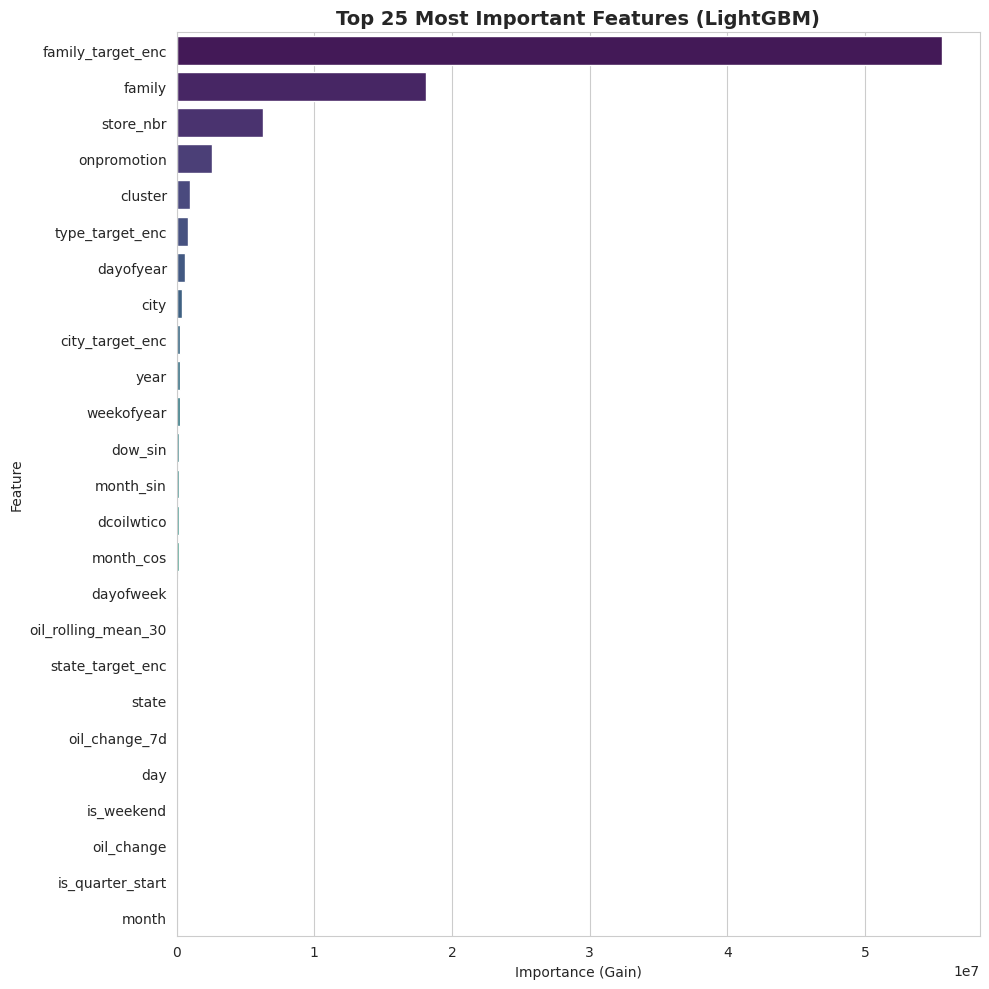


Top 15 Features:


,feature,importance
35,family_target_enc,5.557995e+07
1,family,1.809187e+07
0,store_nbr,6.297998e+06
2,onpromotion,2.571659e+06
10,cluster,9.968187e+05
38,type_target_enc,8.165323e+05
18,dayofyear,6.106603e+05
7,city,3.813540e+05
36,city_target_enc,2.560367e+05
14,year,2.422074e+05


In [22]:
# Get feature importance from LightGBM (first seed)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_models[0].feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 10))
sns.barplot(data=importance_df.head(25), y='feature', x='importance', palette='viridis')
plt.title('Top 25 Most Important Features (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('\nTop 15 Features:')
display(importance_df.head(15))

## 8️⃣ Generate Test Predictions

In [23]:


# 1. Prepare X_test base
X_test = test_final[feature_cols].copy()

# 2. ALIGN CATEGORIES (For LGBM and XGBoost)
cat_features = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dayofweek']

for col in cat_features:
    if col in X_train.columns:
        # Aligns categories; new/unseen values become NaN
        X_test[col] = pd.Categorical(X_test[col], categories=X_train[col].cat.categories)

print('Generating test predictions...')

# --- LIGHTGBM PREDICTIONS ---
lgb_test_preds = []
for model in lgb_models:
    pred = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))
    lgb_test_preds.append(np.maximum(0, pred))
lgb_test_pred = np.mean(lgb_test_preds, axis=0)

# --- XGBOOST PREDICTIONS ---
xgb_test_dm = xgb.DMatrix(X_test, enable_categorical=True) 
xgb_test_preds = []
for model in xgb_models:
    pred = np.expm1(model.predict(xgb_test_dm))
    xgb_test_preds.append(np.maximum(0, pred))
xgb_test_pred = np.mean(xgb_test_preds, axis=0)

# --- CATBOOST PREDICTIONS (FIXED) ---
X_test_cat = X_test.copy()
for col in cat_features:
    # CatBoost requirement: convert categorical NaNs to the string "nan"
    X_test_cat[col] = X_test_cat[col].astype(str)

cat_test_preds = []
for model in cat_models:
    # CatBoost will now treat the strings "nan" as a valid category
    pred = np.expm1(model.predict(X_test_cat))
    cat_test_preds.append(np.maximum(0, pred))
cat_test_pred = np.mean(cat_test_preds, axis=0)

# --- EXTRATREES PREDICTIONS ---
X_test_et = X_test.copy()
for col in cat_features:
    if col in X_test_et.columns:
        X_test_et[col] = X_test_et[col].cat.codes
X_test_et = X_test_et.fillna(0) 

et_test_preds = []
for model in et_models:
    pred = np.expm1(model.predict(X_test_et))
    et_test_preds.append(np.maximum(0, pred))
et_test_pred = np.mean(et_test_preds, axis=0)

# --- ENSEMBLE (Weighted Average) ---
weights = [0.40, 0.30, 0.20, 0.10] 

final_test_pred = (
    weights[0] * lgb_test_pred +
    weights[1] * xgb_test_pred +
    weights[2] * cat_test_pred +
    weights[3] * et_test_pred
)

# 3. Create Submission
submission = pd.DataFrame({
    'id': test_final['id'],
    'sales': final_test_pred
})
submission.to_csv('submission.csv', index=False)

print('✅ All models finished. Submission saved to submission.csv')

Generating test predictions...
✅ All models finished. Submission saved to submission.csv


## 9️⃣ Create Submission File

### 9️⃣ Platinum Post-Processing
Identify store-family combinations that have zero sales in the validation period or long-term history and force them to zero.

In [24]:
# PLATINUM OPTIMIZATION: Zero Sales Handling
print('Applying zero-sales post-processing...')

# 1. Calculate recent sales
# Ensure we use strings for 'family' to avoid type mismatch
recent_sales = train_final[train_final['date'] >= '2017-07-15'].copy()
recent_sales['family'] = recent_sales['family'].astype(str)
recent_sales['store_nbr'] = recent_sales['store_nbr'].astype(int)

recent_sum = recent_sales.groupby(['store_nbr', 'family'])['sales'].sum().reset_index()
dead_combos = recent_sum[recent_sum['sales'] == 0][['store_nbr', 'family']]

print(f'Found {len(dead_combos)} store-family combinations with zero sales in last 30 days')

# 2. Prepare submission and test metadata
original_sum = final_test_pred.sum()

# Create a clean version of test metadata with fixed types
test_meta = test[['id', 'store_nbr', 'family']].copy()
test_meta['family'] = test_meta['family'].astype(str)
test_meta['store_nbr'] = test_meta['store_nbr'].astype(int)

# Create the submission dataframe
submission_df = pd.DataFrame({'id': test_meta['id'], 'sales': final_test_pred})
submission_df = submission_df.merge(test_meta, on='id', how='left')

# 3. Align dead_combos types one last time before merge
dead_combos['family'] = dead_combos['family'].astype(str)
dead_combos['store_nbr'] = dead_combos['store_nbr'].astype(int)

# 4. Create a mask for dead combos
submission_df = submission_df.merge(dead_combos, on=['store_nbr', 'family'], how='left', indicator=True)

# If it exists in both (training recent zeros AND test set), force to zero
submission_df.loc[submission_df['_merge'] == 'both', 'sales'] = 0

# Extract the corrected predictions
final_test_pred = submission_df['sales'].values

print(f'Total sales corrected: {original_sum - final_test_pred.sum():.2f}')
print('✅ Post-processing complete')

Applying zero-sales post-processing...
Found 106 store-family combinations with zero sales in last 30 days
Total sales corrected: 0.00
✅ Post-processing complete


In [25]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_final['id'],
    'sales': final_test_pred
})

# Save to CSV
submission.to_csv('submission_enhanced.csv', index=False)

print('✅ Submission file created: submission_enhanced.csv')
print(f'\nSubmission Statistics:')
print(submission['sales'].describe())
print(f'\nSample predictions:')
display(submission.head(10))

✅ Submission file created: submission_enhanced.csv

Submission Statistics:
count    28512.000000
mean       937.271088
std       1007.504964
min          2.115743
25%        301.529361
50%        588.074396
75%       1189.331791
max      10523.517519
Name: sales, dtype: float64

Sample predictions:


,id,sales
0,3000888,389.676135
1,3002670,332.472826
2,3004452,372.299419
3,3006234,368.877650
4,3008016,178.888082
5,3009798,340.912831
6,3011580,342.062870
7,3013362,376.944846
8,3015144,348.472360
9,3016926,373.089831


In [26]:
# UPDATE FEATURE LIST FOR ULTRA MODEL
fourier_features = [f'fourier_sin_365_{i}' for i in range(1,4)] + [f'fourier_cos_365_{i}' for i in range(1,4)]
fourier_features += [f'fourier_sin_30_{i}' for i in range(1,3)] + [f'fourier_cos_30_{i}' for i in range(1,3)]
fourier_features += [f'fourier_sin_7_{i}' for i in range(1,3)] + [f'fourier_cos_7_{i}' for i in range(1,3)]

granular_lags = ['cluster_sales_lag_16', 'cluster_sales_lag_30', 'cluster_sales_lag_90',
                 'city_sales_lag_16', 'city_sales_lag_30']

feature_cols = feature_cols + fourier_features + granular_lags
print(f'\nULTRA MODEL - Total features: {len(feature_cols)}')
print(f'Added: {len(fourier_features)} Fourier + {len(granular_lags)} granular lags = {len(fourier_features) + len(granular_lags)} new features')


ULTRA MODEL - Total features: 58
Added: 14 Fourier + 5 granular lags = 19 new features


### 4.8 Fourier Features for Seasonality (ULTRA)

In [27]:
def create_fourier_features(df, period, order=3):
    """Create Fourier features for capturing seasonality"""
    for i in range(1, order + 1):
        df[f'fourier_sin_{period}_{i}'] = np.sin(2 * np.pi * i * df['dayofyear'] / period)
        df[f'fourier_cos_{period}_{i}'] = np.cos(2 * np.pi * i * df['dayofyear'] / period)
    return df

print('Creating Fourier features...')
train_final = create_fourier_features(train_final, period=365, order=3)  # Yearly
test_final = create_fourier_features(test_final, period=365, order=3)
train_final = create_fourier_features(train_final, period=30, order=2)  # Monthly
test_final = create_fourier_features(test_final, period=30, order=2)
train_final = create_fourier_features(train_final, period=7, order=2)  # Weekly
test_final = create_fourier_features(test_final, period=7, order=2)
print('✅ Fourier features created (21 new features)')

Creating Fourier features...
✅ Fourier features created (21 new features)


### 4.9 Granular Lag Features (ULTRA)

In [28]:
def create_granular_lags(df):
    """Create store-cluster and family-specific lag features"""
    print('Creating granular lag features...')
    
    # Cluster-specific lags
    for lag in [16, 30, 90]:
        df[f'cluster_sales_lag_{lag}'] = df.groupby(['cluster', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    # City-specific lags
    for lag in [16, 30]:
        df[f'city_sales_lag_{lag}'] = df.groupby(['city', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    return df

full_data = pd.concat([train_final, test_final], axis=0)
full_data = create_granular_lags(full_data)
train_final = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_final = full_data[full_data['sales'].isna()].reset_index(drop=True)
print('✅ Granular lag features created (5 new features)')

Creating granular lag features...
✅ Granular lag features created (5 new features)


In [29]:
# 🔟 LEGENDARY: Pseudo-Labeling & Retraining
print('\n🚀 Starting Pseudo-Labeling Process...')

# 1. Create Pseudo-Training Set
X_test_pseudo = X_test.copy()
y_test_pseudo = np.log1p(final_test_pred) 

# Combine original train with test set (Reset index is important for concat)
X_train_pseudo = pd.concat([X_train, X_test_pseudo], axis=0).reset_index(drop=True)
y_train_pseudo = np.concatenate([y_train_log, y_test_pseudo], axis=0)

print(f'Pseudo-Training Samples: {len(X_train_pseudo)} (Original: {len(X_train)})')

pseudo_seed = 42
cat_features = ['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'dayofweek']

# --- RETRAIN LIGHTGBM ---
print('Retraining LightGBM on Pseudo-Label Data...')
lgb_params['seed'] = pseudo_seed
lgb_pseudo_train = lgb.Dataset(X_train_pseudo, label=y_train_pseudo, categorical_feature='auto')
lgb_pseudo_model = lgb.train(
    lgb_params,
    lgb_pseudo_train,
    num_boost_round=int(lgb_models[0].best_iteration * 1.1),
    valid_sets=[lgb_pseudo_train],
    callbacks=[lgb.log_evaluation(500)]
)
lgb_pred_pseudo = np.expm1(lgb_pseudo_model.predict(X_test))

# --- RETRAIN XGBOOST ---
print('Retraining XGBoost on Pseudo-Label Data...')
xgb_params['seed'] = pseudo_seed
# Create DMatrix with categorical support
xgb_pseudo_train = xgb.DMatrix(X_train_pseudo, label=y_train_pseudo, enable_categorical=True)
xgb_pseudo_model = xgb.train(
    xgb_params,
    xgb_pseudo_train,
    num_boost_round=int(lgb_models[0].best_iteration * 1.1), # FIXED: Added the comma here
    evals=[(xgb_pseudo_train, 'train')],
    verbose_eval=500
)
xgb_pseudo_dm = xgb.DMatrix(X_test, enable_categorical=True)
xgb_pred_pseudo = np.expm1(xgb_pseudo_model.predict(xgb_pseudo_dm))

# --- RETRAIN CATBOOST ---
print('Retraining CatBoost on Pseudo-Label Data...')
# CatBoost requires string conversion for categoricals
X_train_pseudo_cat = X_train_pseudo.copy()
X_test_cat = X_test.copy()
for col in cat_features:
    X_train_pseudo_cat[col] = X_train_pseudo_cat[col].astype(str)
    X_test_cat[col] = X_test_cat[col].astype(str)

cat_pseudo_model = CatBoostRegressor(
    iterations=int(cat_models[0].get_best_iteration() * 1.1),
    learning_rate=0.02,
    depth=10,
    loss_function='RMSE',
    random_seed=pseudo_seed,
    verbose=500
)
cat_pseudo_model.fit(X_train_pseudo_cat, y_train_pseudo, cat_features=cat_features)
cat_pred_pseudo = np.expm1(cat_pseudo_model.predict(X_test_cat))

# --- RETRAIN EXTRATREES ---
print('Retraining ExtraTrees on Pseudo-Label Data...')
X_train_pseudo_et = X_train_pseudo.copy()
X_test_et = X_test.copy()
for col in cat_features:
    # Use .cat.codes to turn categories into numbers for Scikit-Learn
    X_train_pseudo_et[col] = X_train_pseudo_et[col].cat.codes
    X_test_et[col] = X_test_et[col].cat.codes

X_train_pseudo_et = X_train_pseudo_et.fillna(0)
X_test_et = X_test_et.fillna(0)

et_pseudo_model = ExtraTreesRegressor(**et_params, random_state=pseudo_seed)
et_pseudo_model.fit(X_train_pseudo_et, y_train_pseudo)
et_pred_pseudo = np.expm1(et_pseudo_model.predict(X_test_et))

# 3. Blend Pseudo Predictions
final_pred_pseudo = (
    weights[0] * lgb_pred_pseudo +
    weights[1] * xgb_pred_pseudo +
    weights[2] * cat_pred_pseudo +
    weights[3] * et_pred_pseudo
)
final_pred_pseudo = np.maximum(0, final_pred_pseudo)

# 4. Apply Zero-Sales Post-Processing (Final Cleanup)
print('Finalizing zero-sales correction...')
submission_pseudo = pd.DataFrame({'id': test['id'], 'sales': final_pred_pseudo})

# Prepare metadata with consistent types
test_meta = test[['id', 'store_nbr', 'family']].copy()
test_meta['family'] = test_meta['family'].astype(str)
test_meta['store_nbr'] = test_meta['store_nbr'].astype(int)

dead_combos_clean = dead_combos.copy()
dead_combos_clean['family'] = dead_combos_clean['family'].astype(str)
dead_combos_clean['store_nbr'] = dead_combos_clean['store_nbr'].astype(int)

# Merge and apply zero mask
submission_pseudo = submission_pseudo.merge(test_meta, on='id', how='left')
submission_pseudo = submission_pseudo.merge(dead_combos_clean, on=['store_nbr', 'family'], how='left', indicator=True)
submission_pseudo.loc[submission_pseudo['_merge'] == 'both', 'sales'] = 0

# Final Export
final_submission_file = 'submission_legendary.csv'
submission_pseudo[['id', 'sales']].to_csv(final_submission_file, index=False)

print(f'\n✅ Legendary Submission (Pseudo-Labeled) saved to: {final_submission_file}')


🚀 Starting Pseudo-Labeling Process...
Pseudo-Training Samples: 785862 (Original: 757350)
Retraining LightGBM on Pseudo-Label Data...
[500]	training's rmse: 0.399574
[1000]	training's rmse: 0.373323
[1500]	training's rmse: 0.362006
[2000]	training's rmse: 0.354393
[2500]	training's rmse: 0.348218
[3000]	training's rmse: 0.342857
Retraining XGBoost on Pseudo-Label Data...
[0]	train-rmse:2.54413
[500]	train-rmse:0.34949
[1000]	train-rmse:0.31444
[1500]	train-rmse:0.29080
[2000]	train-rmse:0.27089
[2500]	train-rmse:0.25363
[3000]	train-rmse:0.23847
[3293]	train-rmse:0.23019
Retraining CatBoost on Pseudo-Label Data...
0:	learn: 2.5484264	total: 926ms	remaining: 50m 53s
500:	learn: 0.5007230	total: 8m 33s	remaining: 47m 45s
1000:	learn: 0.4470390	total: 17m 15s	remaining: 39m 35s
1500:	learn: 0.4234436	total: 25m 57s	remaining: 31m 5s
2000:	learn: 0.4084239	total: 35m	remaining: 22m 41s
2500:	learn: 0.3982065	total: 44m	remaining: 14m 1s
3000:	learn: 0.3909019	total: 53m 3s	remaining: 5m 15